# Normal Distribution with a Prior

An example of trying to estimate a quantity which cannot be smaller than zero and we believe is small. Normally distributed errors are assumed.

In [1]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

import pystan

In [2]:
model_code = """
data {
    int<lower=1> N;
    real y[N];
    
    real lam;
}

parameters {
    real<lower=0> mu;
}

model {
    mu ~ exponential(lam);

    y ~ normal(mu, 1);
}
"""
model = pystan.StanModel(model_code=model_code)

In [3]:
observations = np.random.normal(size=50) + 0.1
data = dict(y=observations, N=len(observations), lam=2.)

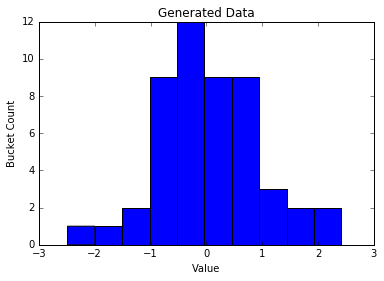

In [4]:
fig, ax = plt.subplots(1, 1)

ax.set_title('Generated Data')
ax.set_xlabel('Value')
ax.set_ylabel('Bucket Count')
ax.hist(observations)
plt.show()

In [5]:
fit = model.sampling(data=data)
samples = fit.extract()
print fit

Inference for Stan model: anon_model_86c3440801ae2ef91473f8c95eb1e6ae.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     0.11  3.3e-3   0.08 6.2e-3   0.04   0.09   0.16   0.32  625.0    1.0
lp__ -24.95    0.04   0.75 -27.11  -25.2 -24.65 -24.42 -24.35  457.0    1.0

Samples were drawn using NUTS(diag_e) at Thu Mar  3 16:33:43 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


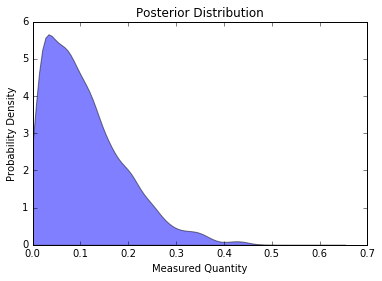

In [6]:
import scipy.stats

def plot_kde_density_1d(d, ax=plt, **kwargs):
    kernel = scipy.stats.gaussian_kde(d)
    mid = d.mean()
    under = d.min() - mid
    over  = d.max() - mid
    x = np.linspace(mid + under, mid + 1.5*over, 100)
    ax.fill_between(x, kernel(x), **kwargs)

fig, ax = plt.subplots(1, 1)

ax.set_title('Posterior Distribution')
ax.set_xlabel('Measured Quantity')
ax.set_ylabel('Probability Density')
plot_kde_density_1d(samples['mu'], ax=ax, alpha=.5)

fig.show()

# Priors Matter

Without a prior, the standard calculation for confidence intervals yields lower bounds below zero, making them very hard to interpret.

In [7]:
mu_hat = observations.mean()
err = 1.96 * observations.std() / np.sqrt(observations.shape[0])

print "Simple frequentist estimate:"

print "{} ± {}".format(np.round(mu_hat, 2),
                       np.round(err, 2))

print "{} / {} / {}".format(np.round(mu_hat - err, 2),
                            np.round(mu_hat, 2),
                            np.round(mu_hat + err, 2))

Simple frequentist estimate:
0.03 ± 0.26
-0.23 / 0.03 / 0.29
